# History Matching for L96
Author : Homer Durand

last modification : 28-07-21

### Loading libs

In [1]:
current_dir <- getwd()
mogp_dir <- paste0(current_dir, "/mogp-emulator") #mogp_emulator lib

setwd(paste0(current_dir, '/dev_ExeterUQ_MOGP/'))

source("BuildEmulator/BuildEmulator.R")
source("HistoryMatching/HistoryMatching.R")
source("HistoryMatching/impLayoutplot.R")

setwd(current_dir)

L96_amip <- import("L96_amip")
np <- import("numpy")
smt <- import("smt")
sklearn <- import("sklearn")

packages <- c("FactoMineR", "factoextra", "corrplot", 'kernlab', 'pca3d', 'BBmisc', 'comprehenr', 'caret', "future.apply", 'tgp', 'ANN2', 'ramify')
# Install packages not yet installed
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
}

# Packages loading
invisible(lapply(packages, library, character.only = TRUE))

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Loading required package: future

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.88 loaded

# History Matching

1. Space filling design of parameters space
2. Data simulation
3. Training of statistical emulator
4. Computation of implausibility
5. Refocussing
    * If stoping criterion is reached stop HM
    * Else, redefining parameters space and go to 1.

## Observations generation

As our model is a toy model we need to generate *observations* based on the ground truth parameters in order to use them to tune our model. In a realistic model (e.g. an ocean model), observations are metrics based on real observations of the state of the ocean threw time.

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} \underbrace{-h c \bar{Y}_{k}}_{\text {Coupling}}$

$\frac{1}{c} \frac{d Y_{j, k}}{d t}=\underbrace{-b Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{-Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h}{J} X_{k}}_{\text {Coupling }}$

We consider the correct parameters to be h=1, F=10, c=10, b=10 and we will first generate our metrics based on those inputs using the 65 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}_k(Y)=\left(\begin{array}{c}
Y_{j,k} \\
Y_{j,k}Y_{j',k}
\end{array}\right), \forall j, j' \in J \text{ and } k \in K
$$

In [2]:
np$random$seed(as.integer(42))

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

We first iterate 10 iterations in order to access to the steady state of the L96 model

In [3]:
l96_two$iterate(10)

In [4]:
Newinit = l96_two$X
Newinit

[1]  4.42757870 -1.95495041  4.02579735  7.58204632  1.62852532  0.39357305
 [7] -0.27120997  0.50364081  1.39288414  7.19375682  4.24944906  4.31670564
[13] 10.65758988  3.57441467  0.28612741  1.59561931  5.81580349 -0.01928225
[19]  9.29077971  2.98459204  0.23466043 -1.10569887  5.99612019  5.39444981
[25]  1.73690034  0.13736713  1.49172092 -1.82474446 -0.34535066 10.71303763
[31]  1.52854734 -1.29510637  0.11986749  2.52317066  4.46499941 10.24747885

We can use *Newinit* to be sure to start from the attractor of the L96.

In [5]:
np$random$seed(as.integer(42))
n_iter <- 10 
dt <- 0.001
l96_two = L96_amip$L96TwoLevel(save_dt=dt, X_init=Newinit, integration_type='coupled') 

In [6]:
l96_two$iterate(n_iter)

We save the history of X in order to reinject it during the Y integration.

In [7]:
X_init<- l96_two$X

We save the metrics generate with the ground truth parameters (observations).

In [8]:
system.time(observations <- l96_two$mean_stats(ax=as.integer(0), amip_metrics=FALSE))

   user  system elapsed 
  0.103   0.013   0.118 

We now have our ground truth metrics and history of X wo we can tune our model.

### Generation of metrics for the first wave

We first sample the parameters space (input space) using a space filling design (latin hypercube sampling with maximin criterion) and then will generate our metrics for each of those points of the parameter space.

In [9]:
sampler <- import('skopt.sampler')
skSpace <- import('skopt.space')

In [10]:
n_samples <- 40

In [11]:
space <- skSpace$Space(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20))) ##only h,c,b
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave1 <- np$array(lhs$generate(space$dimensions, as.integer(n_samples), random_state=as.integer(42)))

As a rule of thumb, we use 10 samples by paramaters. Here we have 3 parameters to tune (h, c, b), so we use 30 samples.

In [12]:
extract_metrics <- function(p, n_iter, dt, X_init) {
    l96_mip = L96_amip$L96TwoLevel(X_init=X_init, save_dt=dt, dt=dt, noYhist=FALSE, h=p[[1]], F=p[[2]], c=p[[3]], b=p[[4]])
    l96_mip$iterate(n_iter)
    return(l96_mip$mean_stats(ax=as.integer(0), amip_metrics=FALSE))
}

In [13]:
plan(multicore)
metrics_wave1 = future_sapply(1:nrow(inputs_wave1), function(r) extract_metrics(inputs_wave1[r,], n_iter, 0.001, X_init), future.seed=NULL) 

### Create the data matrix
We create a data frame with correct format to train an emulator as it is describe in https://bayesexeter.github.io/ExeterUQ_MOGP/Testing_ExeterUQ_mogp.html

We select 65 metrics for a given k (here $k=0$) in order to fit the emulators in a reasonable amount of time. Here we select the metrics 

$$
\boldsymbol{f}_0(Y)=\left(\begin{array}{c}
Y_{j,0} \\
Y_{j,0}Y_{j',0}
\end{array}\right), \forall j, j' \in J
$$

#### Scaling and Unscaling functions

In [14]:
rangeScale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (range[2] - range[1])*(df[,i] - min)/(max - min) + range[1]
    }
    return(df)
}
                                        
rangeUnscale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (max - min)*(df[,i] - range[1])/(range[2] - range[1]) + min
    }
    return(df)
}

In [15]:
# Arrange inputs (parameters) 
inputs_wave1 <- data.frame(inputs_wave1)
my_bounds <- data.frame(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20)))
inputs_wave1 <- rangeScale(inputs_wave1, my_bounds, range = c(-1, 1))
names(inputs_wave1) <- c('h', 'F', 'c', 'b')


metrics_wave1 <- data.frame(t(metrics_wave1))
N = nrow(inputs_wave1) 
noise <- rnorm(N, 0, 0)
tData <- data.frame(cbind(inputs_wave1, noise, metrics_wave1))
names(tData)[names(tData) == "noise"] <- "Noise"
         
head(tData)

,h,F,c,b,Noise,X1,X2,X3,X4,X5,⋯,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.24272128,-0.0589672,-0.1036056,-0.93729158,0,-0.3196332,-0.8588235,0.2634767,-1.136505,-0.1209333,⋯,0.0020384780,0.0018363060,0.0034061165,0.0019871913,0.0010213155,0.0023135944,6.285411e-04,0.0026813119,0.0015052179,0.0031140014
2,0.74974022,-0.4890278,-0.4040966,0.75287034,0,-1.7805316,-0.8546478,-3.1608300,1.176368,-3.1516293,⋯,0.0491441491,0.0410113195,0.0885878193,0.0393771458,0.0333290777,0.0660184558,3.343089e-02,0.0558310432,0.0531686377,0.0925492983
3,-0.63048968,0.4890101,-0.2089569,-0.87576325,0,1.7359524,2.7023062,2.8678221,2.066101,3.7136464,⋯,0.0688584566,0.0613440781,0.0613022566,0.0649929219,0.0558981891,0.0665546032,5.486098e-02,0.0500471616,0.0673411335,0.0613643590
4,-0.88941915,0.5723452,0.6221371,-0.98601571,0,2.2862217,2.3184236,2.3959479,2.351734,2.4516990,⋯,0.0746118170,0.0725908012,0.0762575512,0.0808047390,0.0786086235,0.0773675685,7.438579e-02,0.0809111094,0.0804475991,0.0780239090
5,-0.56311389,-0.3067018,-0.1841641,0.01920742,0,-2.3957311,0.2220428,-2.1883892,0.205220,-2.4832639,⋯,0.0235850482,0.0860749249,0.0353070198,0.0614292391,0.0417044758,0.0536208263,5.263715e-02,0.0464061939,0.0676689642,0.0338488308
6,-0.05324286,-0.1601800,0.4320671,0.65591650,0,0.1248597,-1.7599954,0.1626364,-1.837234,-0.6007457,⋯,0.0005186244,0.0003603479,0.0003730313,0.0003095734,0.0001177707,0.0004524828,9.828174e-05,0.0003501316,0.0002168176,0.0005327499


### Training emulator

In [16]:
cands <- names(tData)[1:4]
em_wave1 <- BuildNewEmulators(tData, HowManyEmulators = ncol(metrics_wave1), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 1.75819673989321 using F"
[1] "Max reduction is 0.0470694248377352 using c"
[1] "Max reduction is 0.02617992389365 using F"
[1] "Max reduction is 0.0258613288984443 using F"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ F + I(F^2) + I(F^3) + c + I(c * F), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.21588 -0.35352 -0.05821  0.36491  1.81402 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.08633    0.15171   0.569  0.57306    
F            4.82482    0.44232  10.908  1.2e-12 ***
I(F^2)      -0.70440    0.33837  -2.082  0.04496 *  
I(F^3)      -1.33341    0.67559  -1.974  0.05659 .  
c           -0.20589    0.17641  -1.167  0.25129    
I(c * F)     0.83171    0.29756   2.795  0.00847 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6379 on 34 degrees of freedom
Multiple R-squared:  0.943,	Adjusted R-squared:  0.9346 
F-statistic: 112

We can use Leave One Out to verify if our GPs fit our metrics correctly.

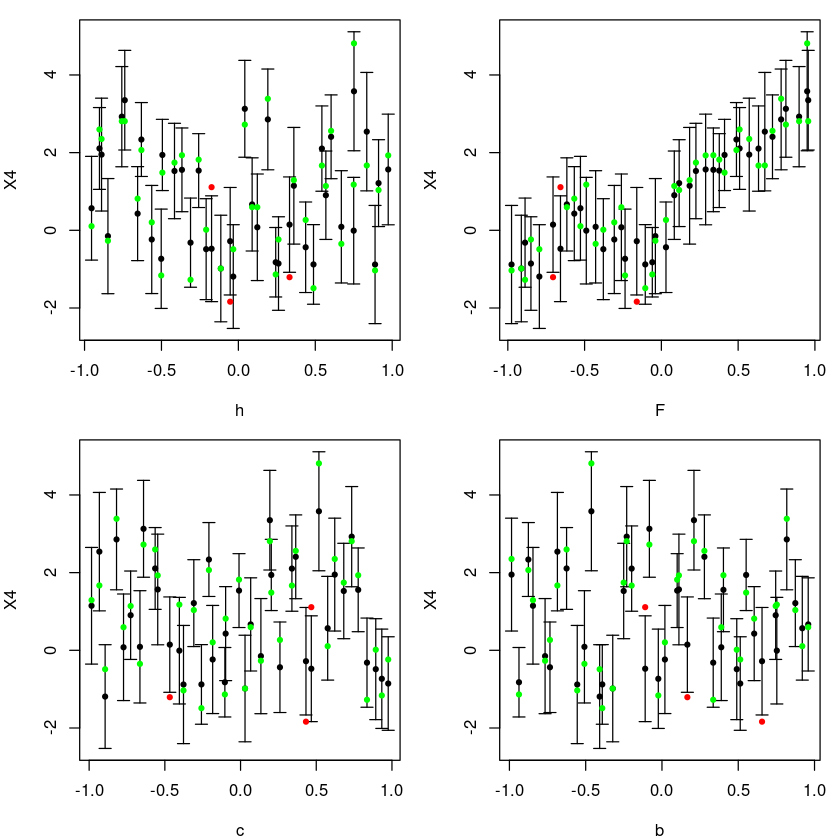

In [17]:
tLOOs <- LOO.plot(Emulators = em_wave1, which.emulator = 4, ParamNames = cands)

### Compute implausibility

We will compute implausibility as it is described in *Williamson & al. (2017)*.

$$
I_i(x_0) = \frac{|z_i - \mathbf{E}[f_i(x_0)]|}{|Var[z_i - \mathbf{E}[f_i(x_0)]]|} \\
I(x_0) = max_i(I_i(x_0))
$$

We consider that $Var[z_i - \mathbf{E}[f_i(x_0)]] = Var[e] +
Var[g] + Var[f(x_0)]$  like it is describe in *Williamson & al. (2017)*. 

With $Var[e]$ the observational
error variance, $Var[g]$ the model discrepancy variance
and $Var[f(x)]$ the variance of the emulator.

In [18]:
tDisc <- rep(0, ncol(metrics_wave1)) # model discrepancy variance Var[g] 
tObsErr <- rep(0, ncol(metrics_wave1)) # observational error variance Var[e]
tObs <-  as.vector(observations) # Observations

We generate a large sampling of the parameter space (that we have scaled) and will compute implausibility for each point of this parameters space.

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave1$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(em_wave1$fitting.elements$Design)
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off
param.def = data.frame(h=c(1),F=c(10),c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

In [ ]:
NROY1 <- which(rowSums(Timps <= cutoff) >= em_wave1$mogp$n_emulators -valmax)
scoreNROY1 <- length(NROY1)/dim(Xp)[1]
scoreNROY1

The first wave of tuning allowed us to reject approximately 70% of the parameters space.

### Layout of NROY space

In [ ]:
ImpData_wave1 = cbind(Xp, Timps)
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=em_wave1$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY1,sep=""), side=1)

## Second Wave

We will generate a large number of samples in the entire parameters space in order to obtain *n_samples* samples in the NROY space created with the emulator *em_wave1*.

In [25]:
n <- ceiling(n_samples*1.3/scoreNROY1)

In [27]:
space <- skSpace$Space(list(c(-1, 1), c(-1, 1), c(-1, 1))) ## we use a scaled space
lhs <- sampler$Lhs(iterations=as.integer(10))  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

We find the points of NewData wich fall in the NROY space of each emulator in *emulators*.

In [28]:
parameters_space <- function(emulators, NewData, n_samples=n_samples){
    NROY_em <- 1:nrow(NewData)
    for (em in emulators){
        imp_em <- ImplausibilityMOGP(NewData=NewData, Emulator=em, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROY_temp <- which(rowSums(imp_em <= cutoff) >= em$mogp$n_emulators - valmax)
        NROY_em <- intersect(NROY_em, NROY_temp)
    }
    return(sample(NROY_em, n_samples))
}

In [29]:
emulators <- list(em_wave1)
NROY_temp_wave2 <- parameters_space(emulators, inputs_wave2_scaled_temp, 30)

We now have our new inputs for wave 2.

We need to unscale those inputs for metrics simulations.

In [30]:
input_wave2_scaled <- inputs_wave2_scaled_temp[sample(NROY_temp_wave2, n_samples),]
input_wave2 <- rangeUnscale(input_wave2_scaled, my_bounds, range = c(-1, 1))

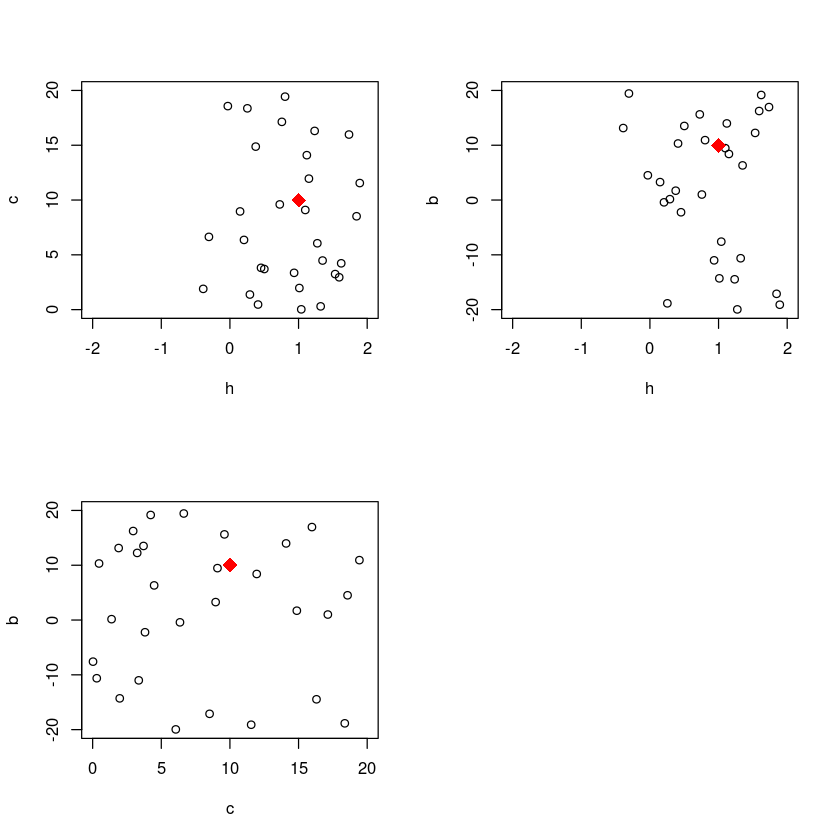

In [31]:
par(mfrow=c(2,2))
plot(input_wave2[,1], input_wave2[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave2[,1], input_wave2[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave2[,2], input_wave2[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [32]:
metrics_wave2 = future_sapply(1:nrow(input_wave2), function(r) extract_metrics_AMIP(input_wave2[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [33]:
input_wave2_scaled <- data.frame(input_wave2_scaled)
names(input_wave2_scaled) <- c('h', 'c', 'b')


metrics_k_wave2 <- data.frame(t(metrics_wave2)[, metrics_index_k])
N = nrow(metrics_k_wave2) 
noise <- rnorm(N, 0, 0)
tData_wave2 <- data.frame(cbind(input_wave2_scaled, noise, metrics_k_wave2))
names(tData_wave2)[names(tData_wave2) == "noise"] <- "Noise"
         
head(tData_wave2)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.1530526,-0.3361236,0.9720859,0,0.013912168,-0.05579715,0.014563931,-0.03950046,0.015298586,-0.05018536,⋯,0.002153506,0.000530957,0.001465042,-0.0003610152,0.005752939,0.0003514342,0.0048220966,0.002005201,-0.0009941468,0.006993797
2,0.2506088,-0.6294510,0.6758554,0,0.061621667,0.08210826,0.077673679,0.08798034,0.046312343,0.08627153,⋯,0.023628816,0.013595129,0.008402983,0.0076162148,0.019661428,0.0095410096,0.0049696264,0.020524109,0.0128248352,0.019981965
3,0.6610673,-0.9702002,-0.5311766,0,0.007720318,0.16360167,0.021531129,0.16377339,0.008857766,0.18850980,⋯,0.015420184,0.006843689,0.011053149,-0.0019389181,0.030980568,0.0024712225,0.0382863696,0.010551442,-0.0034486584,0.070878902
4,0.8675095,0.5975467,0.8481951,0,0.078405222,0.11833268,0.088859763,0.12360403,0.086594392,0.10144461,⋯,0.117055818,0.029048442,0.001176050,0.0162350113,0.100369272,0.0209664142,0.0001775774,0.114117013,0.0216536812,0.088160160
5,0.3784174,0.7133222,0.0502012,0,0.177288609,0.18985428,0.192695864,0.18980542,0.197794950,0.20603834,⋯,0.087298328,0.082859716,0.102508332,0.0988781917,0.079852733,0.0970266202,0.0924898854,0.125540819,0.1175136603,0.118277220
6,0.6172319,0.6306768,-0.7231771,0,0.033416101,0.06499862,0.001973093,0.05518765,0.014186138,0.07658564,⋯,0.030172262,-0.002259494,0.009299290,-0.0025837387,0.038122785,-0.0057514259,0.0180297741,0.034270935,-0.0081169164,0.044552153


### Training emulator

In [34]:
em_wave2 <- BuildNewEmulators(tData_wave2, HowManyEmulators = ncol(metrics_wave2), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.00446367957841858 using b"
[1] "Max reduction is 0.00352491387952267 using h"
[1] "Max reduction is 0.00670103694229086 using b"
[1] "Max reduction is 0.00379310327331508 using b"
[1] "Max reduction is 0.00243913026081448 using b"
[1] "Max reduction is 0.0032238498710622 using Three Way Interactions with b"
[1] "Max reduction is 0.00423436309282937 using c"
[1] "Max reduction is 0.000808976056559149 using b"
[1] "Max reduction is 0.00307063707663819 using b"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = X1 ~ b + I(b^2) + I(b^3) + I(b^4) + I(b^5) + I(b^6) + 
    h + c + I(h * b) + I(c * b) + I(c * h) + I(b * h * b) + I(b * 
    c * b) + I(b * c * h), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.023325 -0.009979 -0.001574  0.007391  0.033100 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.03567    0.01077   3.312  0.00474 ** 
b             0.06032    0

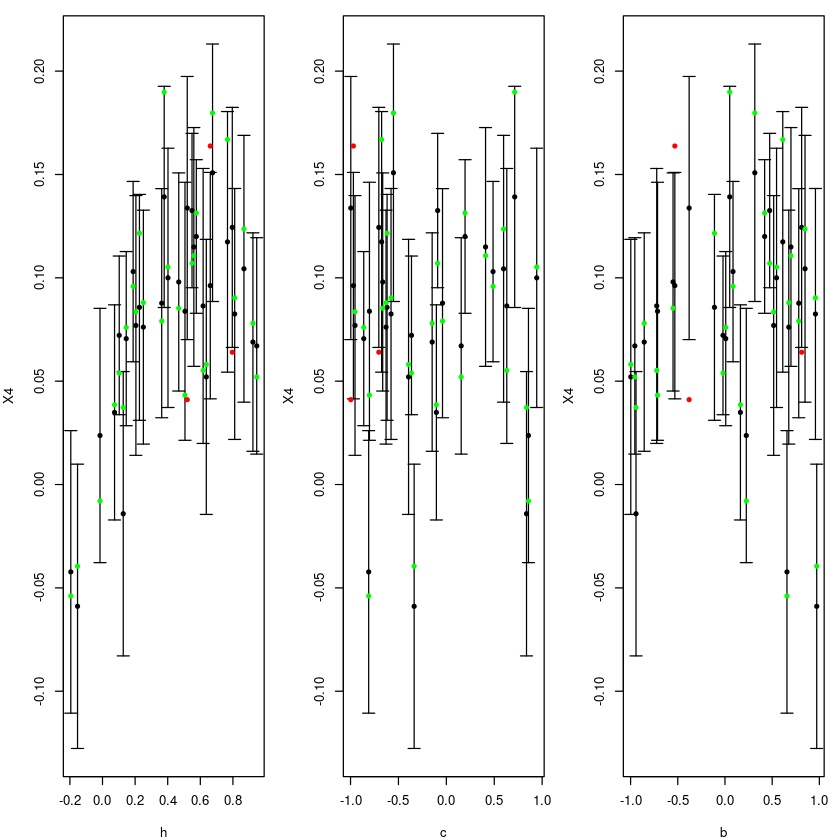

In [35]:
tLOOs <- LOO.plot(Emulators = em_wave2, which.emulator = 4, ParamNames = cands)

### Compute implausibility

In [36]:
sample_size <- 100000
nparam <- length(names(em_wave2$fitting.elements$Design))
Xp_wave2 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave2) <- names(em_wave2$fitting.elements$Design)
system.time(Timps_wave2 <- ImplausibilityMOGP(NewData=Xp_wave2, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 17.476   4.962   4.181 

In [37]:
valmax = 0 #Set to 2 in order to have a "more steady" NROY space
cutoff <- 3 #the implausibility cut off

In [38]:
NROY2 <- which(rowSums(Timps_wave2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)
scoreNROY2 <- length(NROY2)/dim(Xp_wave2)[1]

### Layout of NROY space

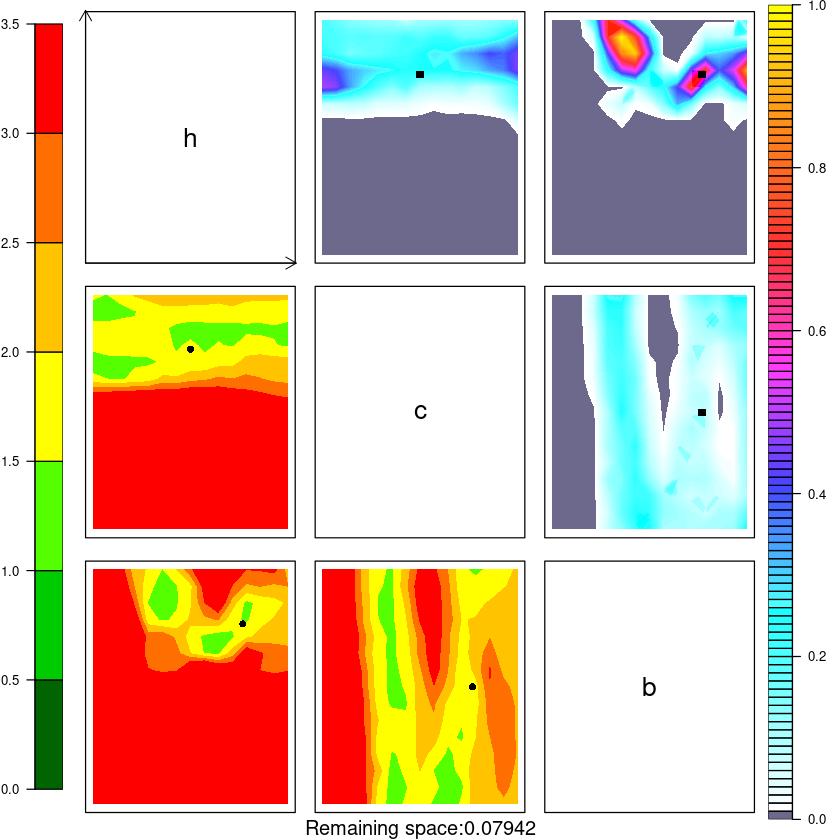

In [39]:
ImpData_wave2 = cbind(Xp_wave2, Timps_wave2)
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=em_wave2$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY2,sep=""), side=1)

## Third Wave

In [40]:
n <- ceiling(n_samples*1.6/scoreNROY2)

In [41]:
inputs_wave3_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [42]:
emulators <- list(em_wave1, em_wave2)
NROY_temp_wave3 <- parameters_space(emulators, inputs_wave3_scaled_temp, n_samples=30)

In [43]:
length(NROY_temp_wave3)

[1] 30

In [44]:
input_wave3_scaled <- inputs_wave3_scaled_temp[sample(NROY_temp_wave3, n_samples),]
input_wave3 <- rangeUnscale(input_wave3_scaled, my_bounds, range = c(-1, 1))

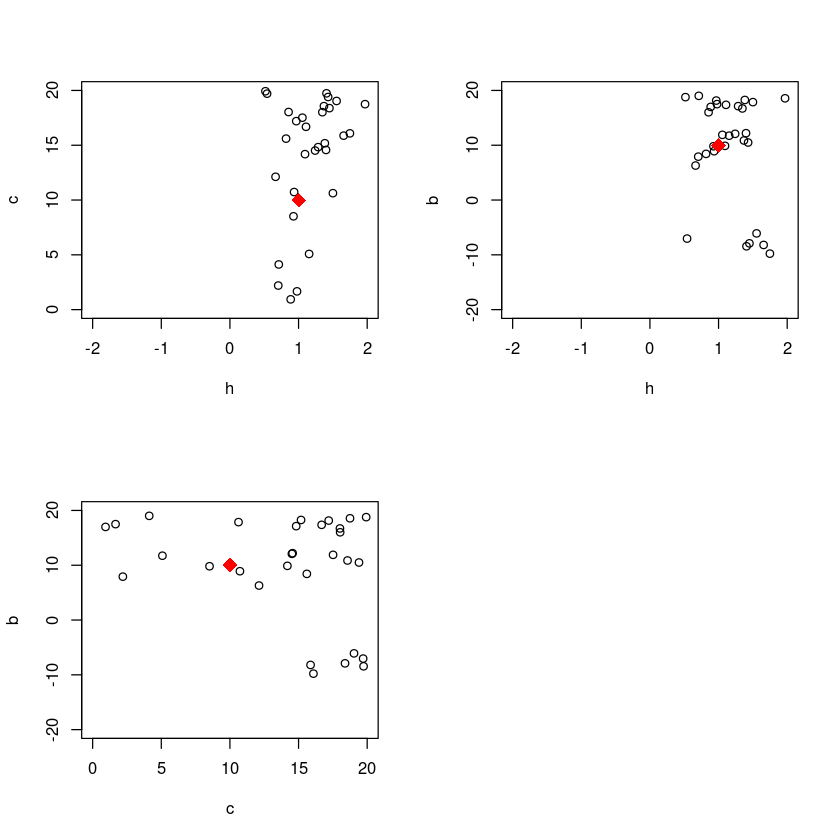

In [45]:
par(mfrow=c(2,2))
plot(input_wave3[,1], input_wave3[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,1], input_wave3[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,2], input_wave3[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [46]:
metrics_wave3 = future_sapply(1:nrow(input_wave3), function(r) extract_metrics_AMIP(input_wave3[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [47]:
input_wave3_scaled <- data.frame(input_wave3_scaled)
names(input_wave3_scaled) <- c('h', 'c', 'b')


metrics_k_wave3 <- data.frame(t(metrics_wave3)[, metrics_index_k])
N = nrow(metrics_k_wave3) 
noise <- rnorm(N, 0, 0)
tData_wave3 <- data.frame(cbind(input_wave3_scaled, noise, metrics_k_wave3))
names(tData_wave3)[names(tData_wave3) == "noise"] <- "Noise"
         
head(tData_wave3)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7000082,0.4568823,0.6098854,0,0.08697405,0.09598750,0.12488378,0.10799416,0.10227512,0.10854848,⋯,0.09878873,0.02670620,0.007525556,0.02021904,0.08568707,0.019387965,-7.878848e-05,0.10732317,0.02934338,0.07811283
2,0.6428040,0.4828659,0.8566116,0,0.06093371,0.06959894,0.11260973,0.07835828,0.06772412,0.08521250,⋯,0.06224068,0.01595211,0.003610132,0.01351924,0.05485957,0.015831311,-2.031128e-03,0.07698508,0.01921164,0.05668620
3,0.4630643,-0.1485233,0.4907544,0,0.10816766,0.12161869,0.08574133,0.11743890,0.10113689,0.08513294,⋯,0.04825797,0.02339612,0.007410846,0.01392696,0.05554142,0.024972046,7.969435e-03,0.05474679,0.02150597,0.04671654
4,0.6849875,0.8567796,0.5432950,0,0.12843641,0.13730965,0.11024035,0.14696728,0.13007793,0.10952540,⋯,0.11010608,0.03692457,0.005472267,0.02810377,0.10228291,0.032802321,2.699616e-03,0.09842996,0.02542183,0.08465873
5,0.7770775,0.9040029,-0.3041323,0,-0.07689518,0.22491535,-0.10764019,0.18571119,-0.12644237,0.19048740,⋯,0.02728663,-0.01841342,0.017146485,-0.02207591,0.11856012,0.005553794,6.982830e-02,0.05129084,-0.02210485,0.10130710
6,0.4089114,0.5602391,0.4211996,0,0.11902891,0.10114374,0.09760441,0.13356120,0.09969331,0.08977878,⋯,0.06240545,0.03184812,0.011387712,0.02713015,0.04747153,0.020605393,1.366766e-02,0.03966768,0.02297749,0.06133198


### Training emulator

In [48]:
em_wave3 <- BuildNewEmulators(tData_wave3, HowManyEmulators = ncol(metrics_wave3), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.0169446541813458 using b"
[1] "Max reduction is 0.0138577036408359 using b"
[1] "Max reduction is 0.000964070876630089 using b"
[1] "Max reduction is 0.00290108736017817 using b"
[1] "Max reduction is 0.000807332150832226 using h"
[1] "Max reduction is 0.000868226713875268 using c"
[1] "Max reduction is 0.0022401930301667 using b"
[1] "Max reduction is 0.000963628025412295 using b"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ b + I(b^2) + I(b^3) + I(b^4) + I(b^5) + I(b^6) + 
    h + c + I(h * b) + I(c * b) + I(c * h), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.027619 -0.007699 -0.001178  0.008289  0.027642 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.01270    0.04738  -0.268  0.79177    
b            0.62048    0.11550   5.372 4.18e-05 ***
I(b^2)      -0.23353    0.44533  -0.524  0.60640    
I(b^3)      -2.84009    0.99171  -2.864  0.01032 *  
I(b^4)       1.99286   

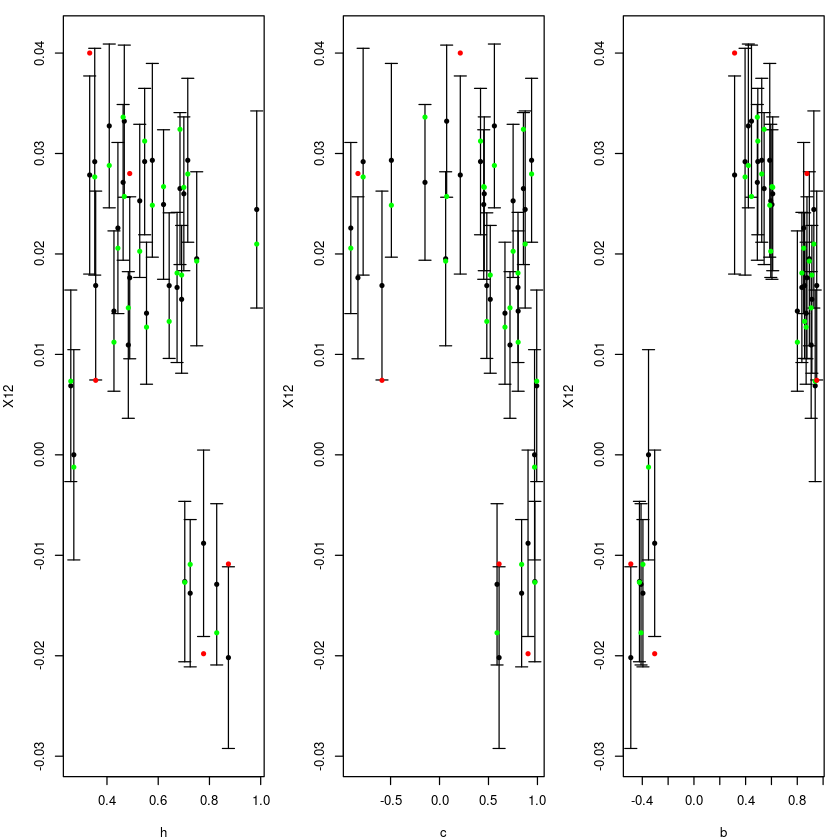

In [49]:
tLOOs <- LOO.plot(Emulators = em_wave3, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [50]:
sample_size <- 100000
nparam <- length(names(em_wave3$fitting.elements$Design))
Xp_wave3 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave3) <- names(em_wave3$fitting.elements$Design)
system.time(Timps_wave3 <- ImplausibilityMOGP(NewData=Xp_wave3, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 17.130   3.370   3.733 

In [66]:
valmax = 2 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [67]:
NROY3 <- which(rowSums(Timps_wave3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)
scoreNROY3 <- length(NROY3)/dim(Xp_wave3)[1]

### Layout of NROY space

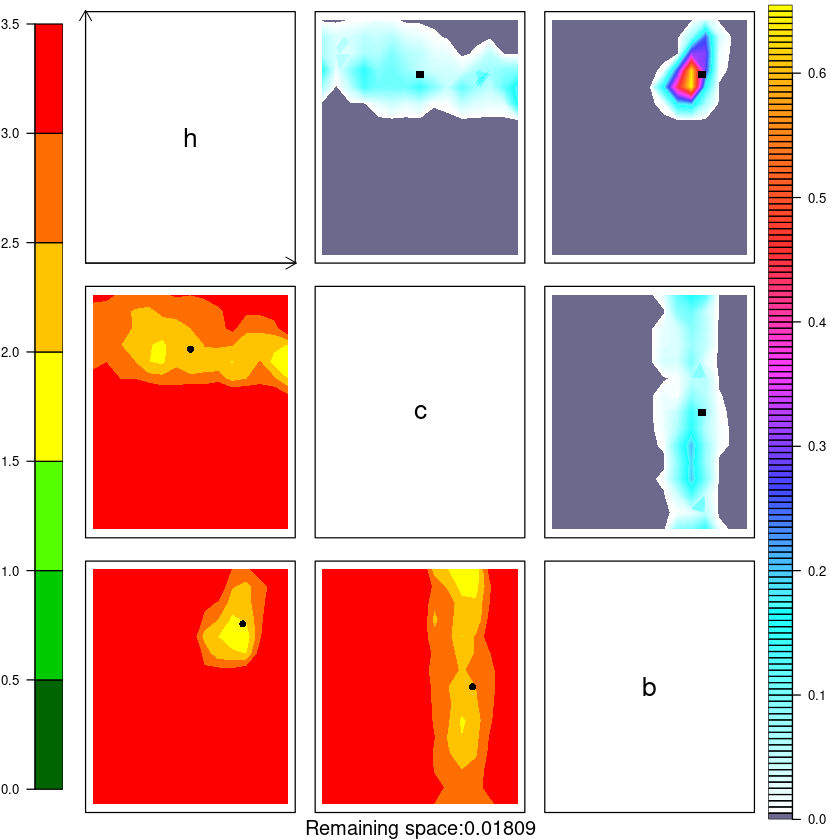

In [68]:
ImpData_wave3 = cbind(Xp_wave3, Timps_wave3)
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=em_wave3$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY3,sep=""), side=1)

## Fourth Wave

In [69]:
n <- ceiling(n_samples*4/scoreNROY3)

In [70]:
inputs_wave4_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [71]:
emulators <- list(em_wave1, em_wave2, em_wave3)
NROY_temp_wave4 <- parameters_space(emulators, inputs_wave4_scaled_temp, 30)

In [72]:
input_wave4_scaled <- inputs_wave4_scaled_temp[sample(NROY_temp_wave4, n_samples),]
input_wave4 <- rangeUnscale(input_wave4_scaled, my_bounds, range = c(-1, 1))

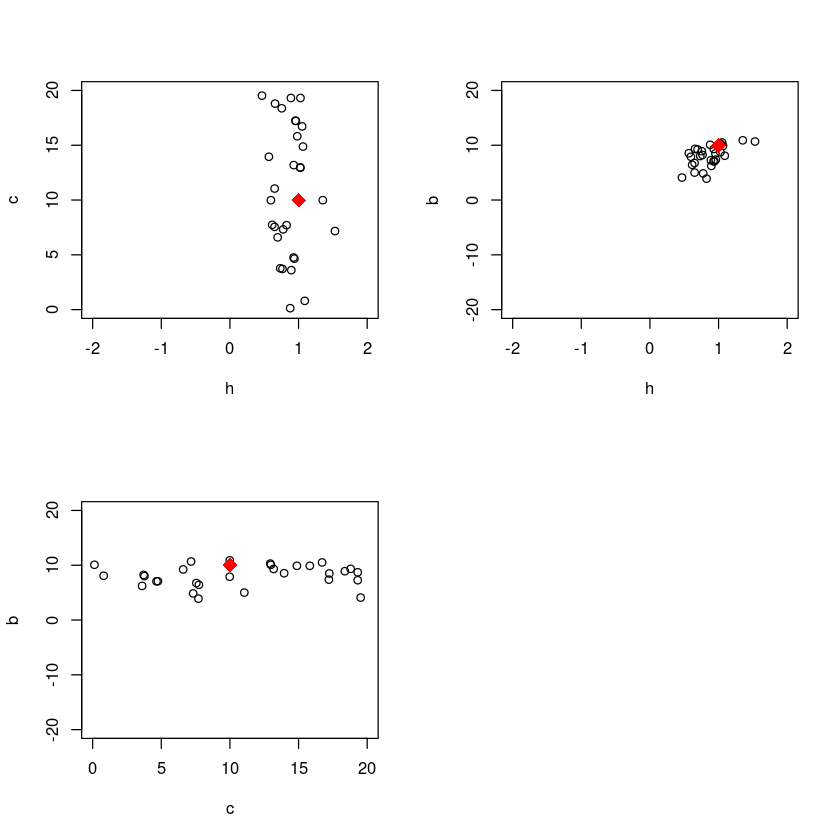

In [73]:
par(mfrow=c(2,2))
plot(input_wave4[,1], input_wave4[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,1], input_wave4[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,2], input_wave4[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [74]:
metrics_wave4 = future_sapply(1:nrow(input_wave4), function(r) extract_metrics_AMIP(input_wave4[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [75]:
input_wave4_scaled <- data.frame(input_wave4_scaled)
names(input_wave4_scaled) <- c('h', 'c', 'b')


metrics_k_wave4 <- data.frame(t(metrics_wave4)[, metrics_index_k])
N = nrow(metrics_k_wave4) 
noise <- rnorm(N, 0, 0)
tData_wave4 <- data.frame(cbind(input_wave4_scaled, noise, metrics_k_wave4))
names(tData_wave4)[names(tData_wave4) == "noise"] <- "Noise"
         
head(tData_wave4)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5125691,0.2983555,0.5036975,0,0.10641687,0.08891493,0.10676659,0.1181666,0.10445329,0.10843071,⋯,0.07238095,0.02959019,0.005740267,0.02229359,0.06194760,0.01737908,0.008521716,0.04796978,0.02215594,0.06310514
2,0.3831185,-0.6286202,0.4118371,0,0.09474141,0.13337213,0.13695590,0.1307762,0.09378861,0.13317199,⋯,0.05205572,0.03029614,0.021995861,0.02225675,0.03927216,0.02687263,0.015396699,0.05894113,0.03566301,0.05067344
3,0.3881903,-0.2677288,0.2428862,0,0.15131920,0.15886096,0.15811395,0.1624435,0.11931373,0.14317511,⋯,0.07267445,0.05019273,0.042610543,0.05747622,0.06424324,0.04788769,0.039965424,0.06962987,0.05186433,0.07455951
4,0.3288121,0.8796062,0.4669828,0,0.10886160,0.08440269,0.08643478,0.1072499,0.09548127,0.07266489,⋯,0.03841884,0.02351667,0.008888847,0.01806240,0.03604708,0.01646690,0.011681712,0.02894494,0.01644853,0.04040079
5,0.7653954,-0.2829753,0.5340643,0,0.10537084,0.10301892,0.13228769,0.1427311,0.11194454,0.11018134,⋯,0.12150794,0.03324402,0.002337051,0.02676369,0.08904866,0.02579678,-0.005363713,0.09003254,0.02737691,0.10649477
6,0.4695863,-0.5347124,0.3531175,0,0.13830389,0.14244328,0.15317089,0.1316076,0.08730770,0.17371519,⋯,0.07683569,0.04152692,0.031653256,0.04467859,0.05516258,0.04041540,0.025436663,0.09425884,0.04679542,0.07804129


### Training emulator

In [76]:
em_wave4 <- BuildNewEmulators(tData_wave4, HowManyEmulators = ncol(metrics_wave4), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.00395856653100607 using b"
[1] "Max reduction is 0.00385076462978739 using h"
[1] "Max reduction is 0.000674473965002417 using c"
[1] "Max reduction is 0.000395408651699602 using c"
[1] "Max reduction is 0.00291877786975382 using Three Way Interactions with c"
[1] "Max reduction is 7.13415241465065e-05 using c"
[1] "Max reduction is 0.00124990962532854 using c"
[1] "Max reduction is 0.000407478606604266 using c"
[1] "Max reduction is 0.00105439398680141 using c"
[1] "No further terms permitted with the given degrees of freedom"

Call:
lm(formula = X1 ~ b + h + c + I(c^2) + I(c^3) + I(c^4) + I(c^5) + 
    I(c^6) + I(h * b) + I(c * b) + I(c * h) + I(c * h * b) + 
    I(c * c * b) + I(c * c * h), data = tData)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0163242 -0.0031181 -0.0009034  0.0044905  0.0128734 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -0.03383    0.07103  -0.476  0.64074   
b             

We can use Leave One Out to verify if our GPs fit our metrics correctly.

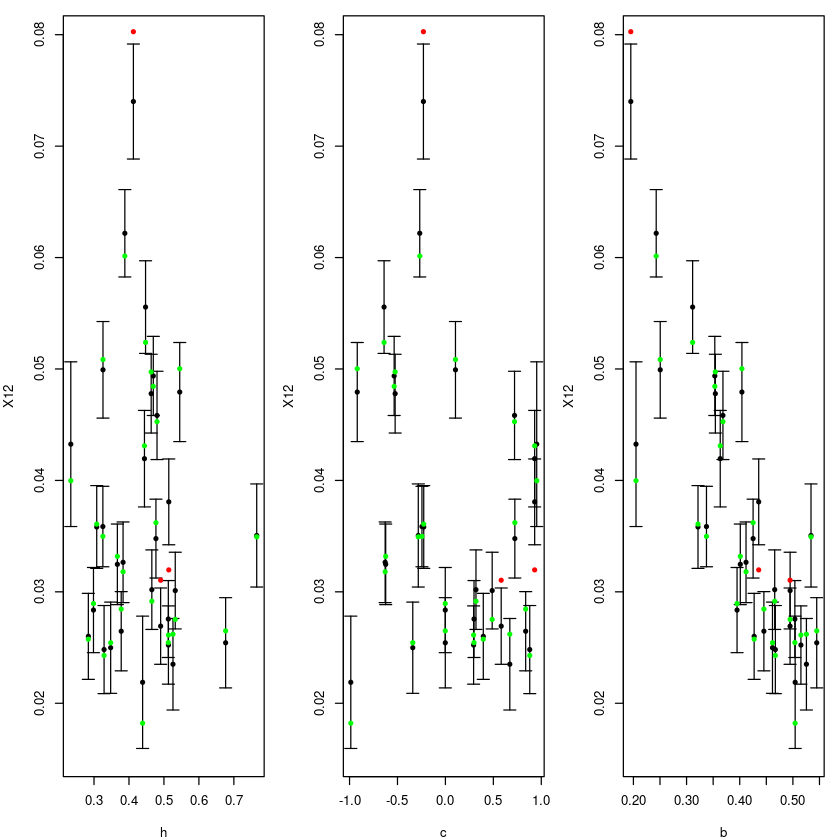

In [77]:
tLOOs <- LOO.plot(Emulators = em_wave4, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [78]:
sample_size <- 100000
nparam <- length(names(em_wave4$fitting.elements$Design))
Xp_wave4 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave4) <- names(em_wave4$fitting.elements$Design)
system.time(Timps_wave4 <- ImplausibilityMOGP(NewData=Xp_wave4, Emulator=em_wave4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 16.550   3.792   3.345 

In [88]:
valmax = 2 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [89]:
NROY4 <- which(rowSums(Timps_wave4 <= cutoff) >= em_wave4$mogp$n_emulators -valmax)
scoreNROY4 <- length(NROY4)/dim(Xp_wave4)[1]

### Layout of NROY space

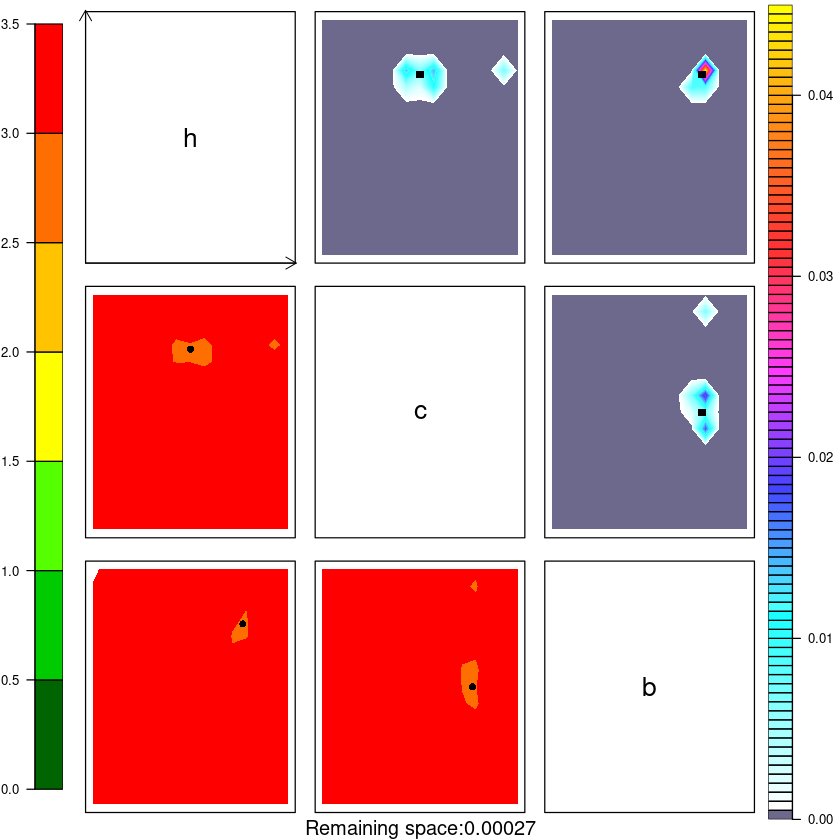

In [90]:
ImpData_wave4 = cbind(Xp_wave4, Timps_wave4)
ImpListM4 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave4, nEms=em_wave4$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM4,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY4,sep=""), side=1)